In [31]:
# cross-validation  

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt 

import pandas
from sklearn import gaussian_process, grid_search, preprocessing, ensemble, linear_model, pipeline, cross_validation 
from numpy import log, inf, linspace, arctan, nan

In [33]:
classifiers = [
    ( 'gaussian_process', gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1) ), 
    ( 'gp2', gaussian_process.GaussianProcess() ), 
]

Text(0.5,1.1,u'gaussian_process')
Text(0.5,1.1,u'gp2')


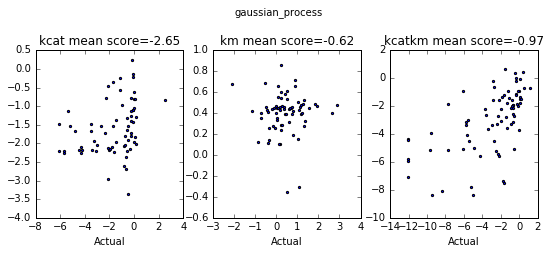

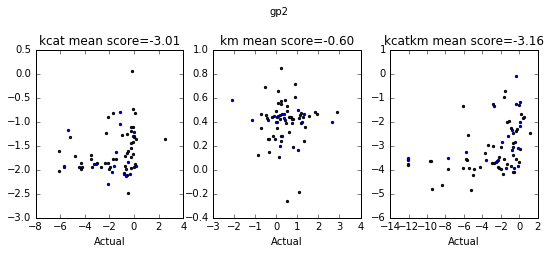

In [35]:
# read in experimental data and log relative to BglB WT 

df = pandas.read_csv( 'data_sets/experimental/plos2015.csv', index_col='name' )
df = log( df / df.loc[ 'BglB' ] )
#df.drop( [ 'BglB' ], inplace=True )

# target, response, dependent variable

targets = [
    ( 'kcat', df.kcat ), 
    ( 'km', df.km ), 
    ( 'kcatkm', df.kcatkm ),
]

# enzyme design features
# sort by lowest 10 total_score (should test all!) 

f = pandas.read_csv( 'data_sets/calculated/enzyme_design_talaris_2013.csv' )  
f = f.groupby( 'name' ).apply( lambda x: x.sort_values( 'total_score' ).head( 10 ).mean() ) 

features = [ 
    u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
    u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
    u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', 
    u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
    u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
    u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
    u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_hbond_pm',
    u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
    u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
    u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
    u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
    u'SR_4_hbond_sc', u'SR_4_hbond_pm',
    u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
    u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', 
    u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
    u'SR_5_burunsat_pm' 
]  

for clf_name, clf in classifiers:
    
    plt.figure( figsize=( 9, 3 ) )
    print plt.suptitle( clf_name, y=1.1 )  
    
    for i, ( name, target ) in enumerate( targets ):

        J = f.join( target ).replace( [ -inf, inf ], nan ).dropna()
        X = J[ features ] 
        y = J[ name ] 

        pln = pipeline.Pipeline([
            ( 'scaler', preprocessing.StandardScaler() ), 
            ( clf_name, clf ), 
        ])

        preds = cross_validation.cross_val_predict( pln, X, y, cv=10 ) 
        scores = cross_validation.cross_val_score( pln, X, y, cv=10 ) 

        plt.subplot( 1, 3, i + 1 ) 
        plt.scatter( y, preds, marker='.' ) 
        plt.xlabel( 'Actual' ) 
        plt.title( '{0} mean score={1:.2f}'.format( name, scores.mean() ) )